In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import  itertools
import scipy.stats as stats
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


In [36]:
import os
import urllib

In [41]:
df1 = pd.read_csv(r'C:\Users\Samrat\Downloads\heart_failure_clinical_records_dataset.csv')

In [42]:
df2 = df1.copy()

In [43]:
df2.rename(columns={'sex':'gender'}, inplace=True)

In [44]:
df2.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
gender                      0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [45]:
df2['gender'].value_counts()

1    194
0    105
Name: gender, dtype: int64

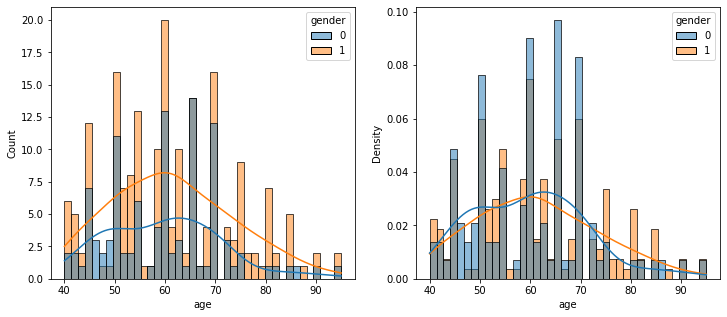

In [46]:
plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(x='age', hue='gender', data=df2, kde=True, bins=40)
plt.subplot(1,2,2)
sns.histplot(x='age', hue='gender', data=df2,stat="density", common_norm=False, kde=True, bins=40)
plt.show()

<AxesSubplot:xlabel='age', ylabel='Density'>

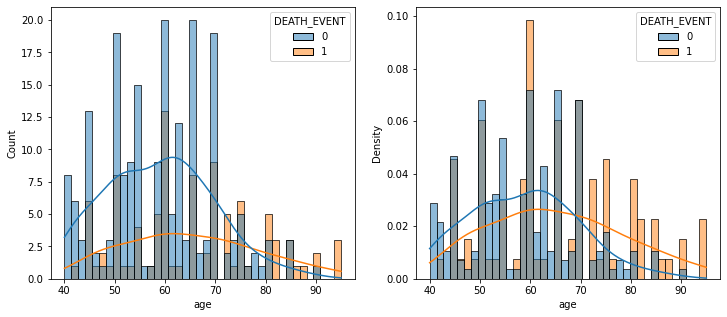

In [47]:
plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(x='age', hue='DEATH_EVENT', data=df2, kde=True, bins=40)
plt.subplot(1,2,2)
sns.histplot(x='age', hue='DEATH_EVENT', data=df2, stat="density", common_norm=False, kde=True, bins=40)

In [48]:
def mortality_single_risk_factor (df, risk_factor): 
    """
    Input df - dataframe as df
    Input risk_factor - one of 'anaemia', 'diabetes', 'high_blood_ressure', 'gender' or 'smoking'
    Outputs - a dictionary containing the mortality fractions in the absence and presence of the risk factor
    """
    negrf_negDeath = df[(df['DEATH_EVENT']==0) & (df[risk_factor]==0)][risk_factor].count()
    negrf_posDeath = df[(df['DEATH_EVENT']==1) & (df[risk_factor]==0)][risk_factor].count()
    posrf_negDeath = df[(df['DEATH_EVENT']==0) & (df[risk_factor]==1)][risk_factor].count()
    posrf_posDeath = df[(df1['DEATH_EVENT']==1) & (df[risk_factor]==1)][risk_factor].count()
    
    frac_without_rf = round(negrf_posDeath/(negrf_negDeath+negrf_posDeath),2)
    frac_with_rf = round(posrf_posDeath/(posrf_negDeath+posrf_posDeath),2)
    return {'-RF':frac_without_rf, '+RF':frac_with_rf}

In [49]:
single_risk_factor={}
risks1= ['anaemia', 'diabetes', 'high_blood_pressure', 'gender', 'smoking']

for risk in risks1:
    single_risk_factor[risk] = mortality_single_risk_factor(df2, risk)
single_risk_factor 

{'anaemia': {'-RF': 0.29, '+RF': 0.36},
 'diabetes': {'-RF': 0.32, '+RF': 0.32},
 'high_blood_pressure': {'-RF': 0.29, '+RF': 0.37},
 'gender': {'-RF': 0.32, '+RF': 0.32},
 'smoking': {'-RF': 0.33, '+RF': 0.31}}

Text(0.5, 0, 'Risk Factor')

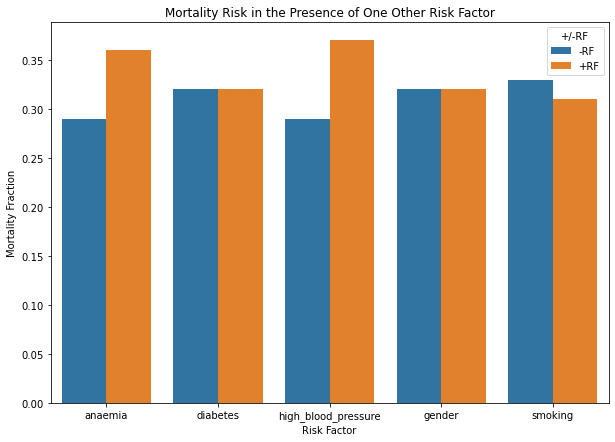

In [50]:
single_risk_df=pd.DataFrame(single_risk_factor)
single_risk_df=single_risk_df.transpose()
single_risk_df=single_risk_df.melt(var_name='+/-RF', value_name='mort_frac',ignore_index=False)


plt.figure(figsize=(10,7))
sns.barplot(x=single_risk_df.index, y=single_risk_df['mort_frac'], hue=single_risk_df['+/-RF'])
plt.title('Mortality Risk in the Presence of One Other Risk Factor')
plt.ylabel('Mortality Fraction')
plt.xlabel('Risk Factor')

In [51]:
def mortality_multiple_risks (df, risk_factor1, risk_factor2):
    """
    Input df - dataframe as df
    Input risk_factor1 & 2 - two of 'anaemia', 'diabetes', 'high_blood_ressure', 'gender' or 'smoking'
    Outputs - a dictionary containing the mortality fractions in the absence and presence of the two risk factors
    """
    
    negrfs_negDeath = df[(df['DEATH_EVENT']==0) & (df[risk_factor1]==0) & (df[risk_factor2]==0)][risk_factor1].count()
    negrfs_posDeath = df[(df['DEATH_EVENT']==1) & (df[risk_factor1]==0) & (df[risk_factor2]==0)][risk_factor1].count()
    posrfs_negDeath = df[(df['DEATH_EVENT']==0) & (df[risk_factor1]==1) & (df[risk_factor2]==1)][risk_factor2].count()
    posrfs_posDeath = df[(df['DEATH_EVENT']==1) & (df[risk_factor1]==1) & (df[risk_factor2]==1)][risk_factor2].count()
    
    frac_without_rfs = round(negrfs_posDeath/(negrfs_negDeath+negrfs_posDeath),2)
    frac_with_rfs = round(posrfs_posDeath/(posrfs_negDeath+posrfs_posDeath),2)


    return {'-RFs':frac_without_rfs, '+RFs':frac_with_rfs}

In [52]:
combs=itertools.combinations(risks1, 2) 
dual_risk={}
for comb in combs:
    dual_risk[str(comb[0]+' & '+comb[1])]=mortality_multiple_risks (df2, comb[0], comb[1])
dual_risk

{'anaemia & diabetes': {'-RFs': 0.29, '+RFs': 0.34},
 'anaemia & high_blood_pressure': {'-RFs': 0.27, '+RFs': 0.4},
 'anaemia & gender': {'-RFs': 0.26, '+RFs': 0.34},
 'anaemia & smoking': {'-RFs': 0.3, '+RFs': 0.35},
 'diabetes & high_blood_pressure': {'-RFs': 0.3, '+RFs': 0.4},
 'diabetes & gender': {'-RFs': 0.28, '+RFs': 0.29},
 'diabetes & smoking': {'-RFs': 0.35, '+RFs': 0.4},
 'high_blood_pressure & gender': {'-RFs': 0.28, '+RFs': 0.36},
 'high_blood_pressure & smoking': {'-RFs': 0.32, '+RFs': 0.47},
 'gender & smoking': {'-RFs': 0.31, '+RFs': 0.29}}

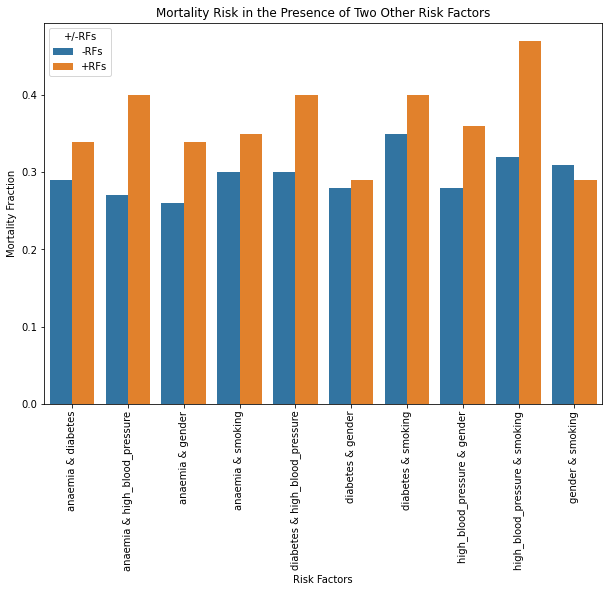

In [53]:
dual_risk_df=pd.DataFrame(dual_risk)
dual_risk_df=dual_risk_df.transpose()
dual_risk_df=dual_risk_df.melt(var_name='+/-RFs', value_name='mort_frac',ignore_index=False)


plt.figure(figsize=(10,7))
sns.barplot(x=dual_risk_df.index, y=dual_risk_df['mort_frac'], hue=dual_risk_df['+/-RFs'])
plt.title('Mortality Risk in the Presence of Two Other Risk Factors')
plt.ylabel('Mortality Fraction')
plt.xlabel('Risk Factors')
plt.xticks(rotation=90)
plt.show()

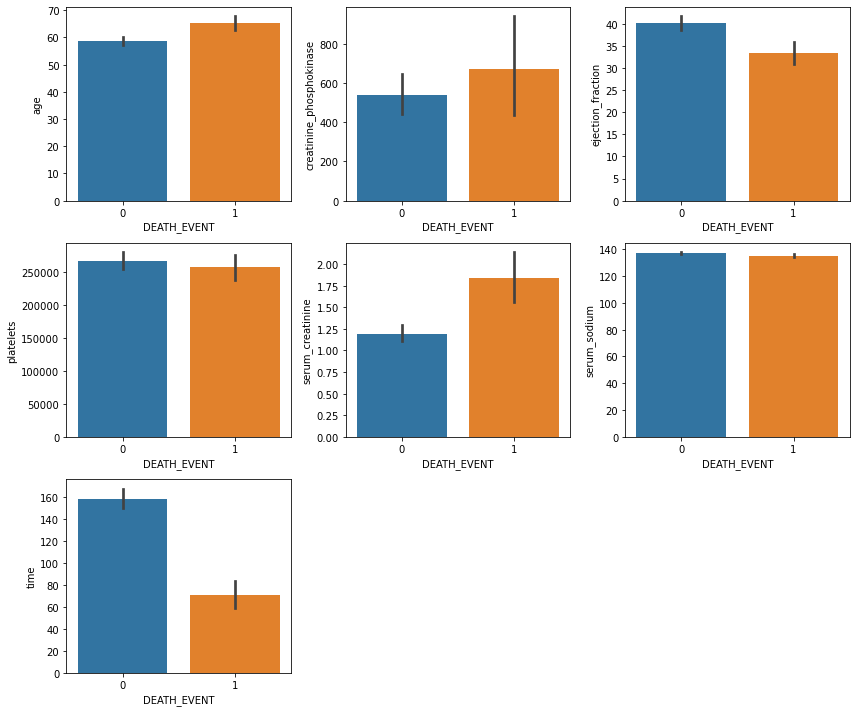

In [54]:
count=1
plt.subplots(figsize=(12, 10))
for marker in ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium', 'time']:
    plt.subplot(3,3,count)
    sns.barplot(x=df2['DEATH_EVENT'], y=df2[marker])
    count+=1
    plt.tight_layout()

plt.show()

In [55]:
markers=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium', 'time']

In [56]:
for marker in markers:
    p_val=stats.ttest_ind(a=df1[df1['DEATH_EVENT']==0][marker], b=df1[df1['DEATH_EVENT']==1][marker])
    if p_val[1]<=0.01:
        print(marker, 'p =', p_val[1], 'p < 0.01 significant')
    elif p_val[1]<=0.05: 
        print(marker, 'p =', p_val[1], 'p < 0.05 significant')
    else: print(marker, 'p =', p_val[1], 'p > 0.05 NOT significant')

age p = 8.916762946533357e-06 p < 0.01 significant
creatinine_phosphokinase p = 0.27961124573614 p > 0.05 NOT significant
ejection_fraction p = 2.452897418208845e-06 p < 0.01 significant
platelets p = 0.3971941540413678 p > 0.05 NOT significant
serum_creatinine p = 2.1901978548979685e-07 p < 0.01 significant
serum_sodium p = 0.0006889112363763486 p < 0.01 significant
time p = 9.122223384926442e-23 p < 0.01 significant


In [57]:
def blood_marker_vs_mortality (df, risk_factor1, risk_factor2, marker, ax=None):
    """
    Input df - dataframe as df
    Input risk_factor1 & 2 - two of 'anaemia', 'diabetes', 'high_blood_ressure', 'gender' or 'smoking'
    Input marker - Risk marker of interst
    Outputs - a dictionary containing the mortality fractions in the absence and presence of the two risk factors
    """
    results_dict={}
    negrfs_negDeath = df[(df['DEATH_EVENT']==0) & (df[risk_factor1]==0) & (df[risk_factor2]==0)][marker]
    negrfs_posDeath = df[(df['DEATH_EVENT']==1) & (df[risk_factor1]==0) & (df[risk_factor2]==0)][marker]
    posrfs_negDeath = df[(df['DEATH_EVENT']==0) & (df[risk_factor1]==1) & (df[risk_factor2]==1)][marker]
    posrfs_posDeath = df[(df['DEATH_EVENT']==1) & (df[risk_factor1]==1) & (df[risk_factor2]==1)][marker]
    
    results_dict['-RF_-D']= negrfs_negDeath
    results_dict['-RF_+D']= negrfs_posDeath
    results_dict['+RF_-D']= posrfs_negDeath
    results_dict['+RF_+D']= posrfs_posDeath
       
    results=pd.DataFrame(results_dict)
    sns.barplot(x=results.columns, y=results[results.columns].mean(), ci=95)
    plt.errorbar(x=results.columns, y=results[results.columns].mean(), yerr=results[results.columns].std(), fmt='none', capsize=5)
    plt.xticks(rotation=90)   

HPB = High blood pressure
+/- RF = presence or absence of added risk factor (for gender: +RF = male -RF=female)
+/- D = presence or absence of death


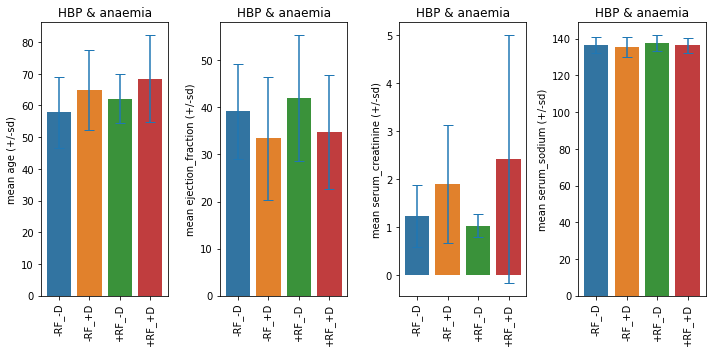

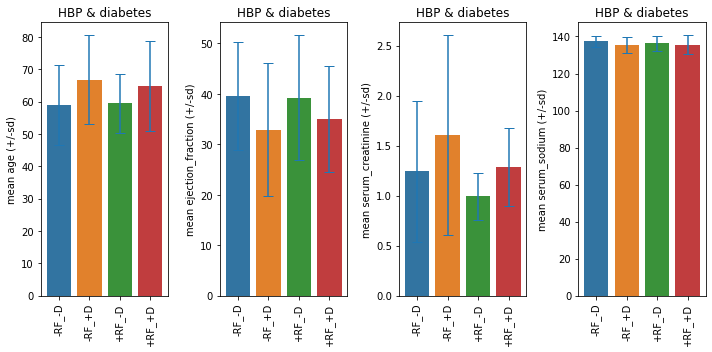

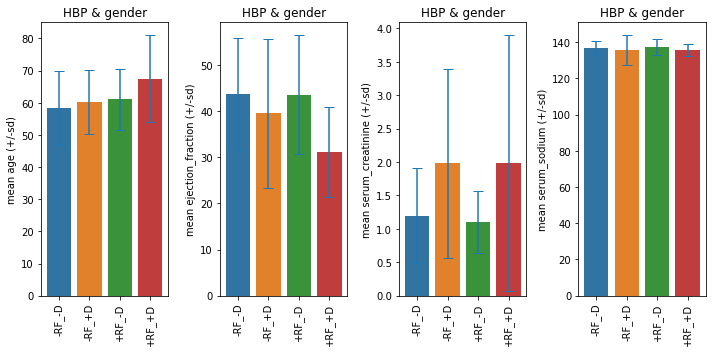

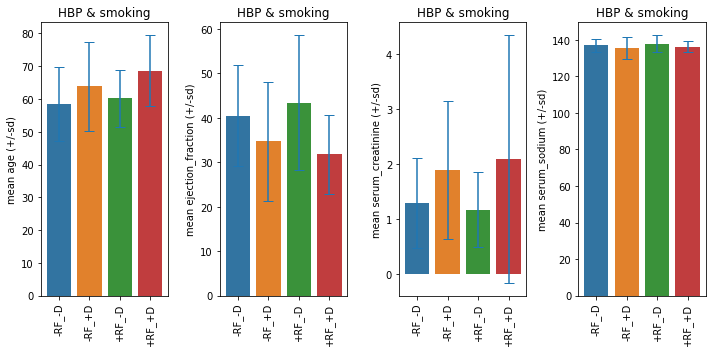

In [58]:
print('HPB = High blood pressure')
print('+/- RF = presence or absence of added risk factor (for gender: +RF = male -RF=female)')
print('+/- D = presence or absence of death')

for risk in ['anaemia', 'diabetes', 'gender', 'smoking']:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,5))
    ind=1
    for marker in ['age','ejection_fraction','serum_creatinine', 'serum_sodium']:
        axes=plt.subplot(1, 4, ind)
        blood_marker_vs_mortality(df2, 'high_blood_pressure',risk, marker, ax=axes)
        plt.ylabel('mean '+marker+' (+/-sd)')
        plt.title('HBP '+'& '+risk)
        ind+=1
        plt.tight_layout()

In [59]:
df2['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [60]:
skf=StratifiedKFold(n_splits=5, shuffle=True) #create a StratifiedKFold object with 5 folds since the  
# survivor/non-survivor groups are imbalanced
scaler = StandardScaler() #create a StandardScaler object to scale the data prior to testing and training

In [61]:
X=df2.drop(['DEATH_EVENT'], axis=1) #independent variables 
X_scaled=scaler.fit_transform(X)#scale the numeric data in the dataframe
y=df2['DEATH_EVENT']#dependent variable (outcome) data

In [62]:
X_scaled[0]

array([ 1.19294523e+00, -8.71104775e-01,  1.65728387e-04, -8.47579380e-01,
       -1.53055953e+00,  1.35927151e+00,  1.68164843e-02,  4.90056987e-01,
       -1.50403612e+00,  7.35688190e-01, -6.87681906e-01, -1.62950241e+00])

In [63]:
df2.head(2)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,gender,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1


In [64]:
pca=PCA(n_components=5) #create a PCA object that retains 5 of the most important features
X_pca=pca.fit_transform(X_scaled)
X_pca.shape

(299, 5)

In [65]:
# create objects for the models to be tested for their ability to predict mortality due to heart failure.
model_logreg = LogisticRegression(max_iter=3500, C=1)
model_SVC=SVC(kernel='rbf', C=5, gamma='auto')
model_rfc=RandomForestClassifier(n_estimators=100)
model_gbc=GradientBoostingClassifier(learning_rate=0.1, max_depth=3)
model_xgb=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.5, max_depth=3)

#create a list of the model objects to be used in the for loop below
models=[model_logreg, model_SVC, model_rfc, model_gbc, model_xgb]

#an empty dictionary for storing average model metric data
score_dict = {'Logistic Regression':{},
              'Support Vector':{},
              'Random Forest':{},
              'Gradient Boost':{},
              'XG Boost':{}
             }
#define if the testing rounds should use X_scaled or X_pca created above
data=X_scaled

#following function inserts model metrics into the score_dict dictionary
def score_dict_edit (model):
    score_dict[model]['accuracy']=np.mean(accuracy_scores)
    score_dict[model]['precision']=np.mean(precision_scores)
    score_dict[model]['recall']=np.mean(recall_scores)
    score_dict[model]['F1']=np.mean(f1_scores)

#loop through the models list and conduct trainin/testing runs with each stratified fold
for model in models: 
    #create empty lists to store the different testing metrics
    accuracy_scores =[]
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for train_index, test_index in skf.split(data, y):        
        X_train = data[train_index]
        X_test = data[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, predict))
        precision_scores.append(precision_score(y_test, predict, average=None)[1])
        recall_scores.append(recall_score(y_test, predict, average=None)[1])
        f1_scores.append(f1_score(y_test, predict, average=None)[1])

        if model==model_logreg:
            score_dict_edit ('Logistic Regression')
        elif model==model_SVC:
            score_dict_edit ('Support Vector')
        elif model==model_rfc:
            score_dict_edit ('Random Forest')
        elif model==model_gbc:
            score_dict_edit ('Gradient Boost')
        else:
            score_dict_edit ('XG Boost')
        
df_data=pd.DataFrame(score_dict).transpose()
df_data


,accuracy,precision,recall,F1
Logistic Regression,0.816271,0.756263,0.657895,0.694798
Support Vector,0.756045,0.637305,0.583684,0.603095
Random Forest,0.839435,0.774646,0.697368,0.730707
Gradient Boost,0.849435,0.816394,0.697895,0.748470
XG Boost,0.822712,0.733030,0.695789,0.710861
